In [45]:
import backtrader as bt
import yfinance as yf
import numpy as np
%matplotlib inline


In [46]:
df = yf.download('AAPL', start='2023-01-01', end='2023-12-31')
df.columns = [col[0] for col in df.columns] # Flatten multi-level column index
print(df.info())
df.head()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  250 non-null    float64
 1   Close      250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Open       250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB
None


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-01-03 00:00:00+00:00,123.904625,125.070000,130.899994,124.169998,130.279999,112117500
2023-01-04 00:00:00+00:00,125.182610,126.360001,128.660004,125.080002,126.889999,89113600
2023-01-05 00:00:00+00:00,123.855103,125.019997,127.769997,124.760002,127.129997,80962700
2023-01-06 00:00:00+00:00,128.412231,129.619995,130.289993,124.889999,126.010002,87754700
2023-01-09 00:00:00+00:00,128.937317,130.149994,133.410004,129.889999,130.470001,70790800


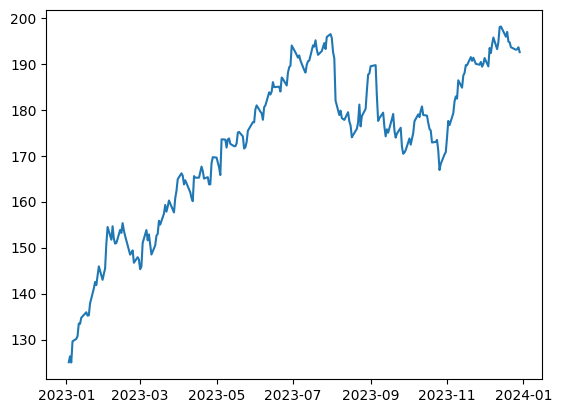

In [47]:
import matplotlib.pyplot as plt
df_plot = df.copy()
df_plot.reset_index(inplace=True)
plt.plot(df_plot['Date'], df_plot['Close'])
plt.show()

In [48]:
data = bt.feeds.PandasData(dataname=df)

In [ ]:
class MeanReversion_BollingerBands(bt.Strategy):
    params = dict(
        period = 20,
        devfactor = 0.5
    )


    def __init__(self):
        self.bollinger = bt.indicators.BollingerBands(
            self.datas[0].close, 
            period = self.params.period, 
            devfactor = self.params.devfactor)
        
        self.dataclose = self.datas[0].close

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime().date()
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted]:
            self.log('Order Submitted')
            pass

        if order.status in [order.Accepted]:
            pass
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Size: %.2f, Value: %.2f, Comm: %.2f' % (order.executed.price, order.executed.size,order.executed.value, order.executed.comm))
            else:
                self.log('SELL EXECUTED, Price: %.2f, Size: %.2f, Value: %.2f, Comm: %.2f' % (order.executed.price, order.executed.size,order.executed.value, order.executed.comm))
        
        if order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        self.order = None

    def next(self):
        # 價格大於布林上限時，賣出
        if self.dataclose[0] > self.bollinger.top and self.position:
            self.order = self.sell()
            pass
        # 價格小於布林下限時，買進
        if self.dataclose[0] < self.bollinger.lines.bot:
            self.order = self.buy()
            pass

Starting Portfolio Value: 10000.0
2023-02-27, Order Submitted
2023-02-27, BUY EXECUTED, Price: 147.71, Size: 1.00, Value: 147.71, Comm: 0.15
2023-02-28, Order Submitted
2023-02-28, BUY EXECUTED, Price: 147.05, Size: 1.00, Value: 147.05, Comm: 0.15
2023-03-01, Order Submitted
2023-03-01, BUY EXECUTED, Price: 146.83, Size: 1.00, Value: 146.83, Comm: 0.15
2023-03-02, Order Submitted
2023-03-02, BUY EXECUTED, Price: 144.38, Size: 1.00, Value: 144.38, Comm: 0.14
2023-03-03, Order Submitted
2023-03-03, BUY EXECUTED, Price: 148.04, Size: 1.00, Value: 148.04, Comm: 0.15
2023-03-07, Order Submitted
2023-03-07, SELL EXECUTED, Price: 153.70, Size: -1.00, Value: 146.80, Comm: 0.15
2023-03-09, Order Submitted
2023-03-09, SELL EXECUTED, Price: 153.56, Size: -1.00, Value: 146.80, Comm: 0.15
2023-03-13, Order Submitted
2023-03-13, BUY EXECUTED, Price: 147.81, Size: 1.00, Value: 147.81, Comm: 0.15
2023-03-15, Order Submitted
2023-03-15, SELL EXECUTED, Price: 151.19, Size: -1.00, Value: 147.05, Comm: 0.

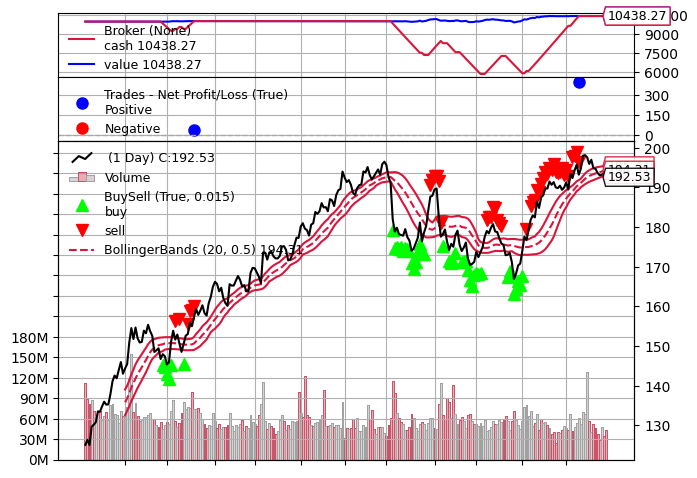

In [57]:
cerebro = bt.Cerebro()
print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
cerebro.adddata(data)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(0.001)

cerebro.addstrategy(MeanReversion_BollingerBands)
cerebro.run(maxcpus=1)
print(f'Final Portfolio Value: {cerebro.broker.getvalue()}')

fig = cerebro.plot(iplot=False)[0][0]
fig.savefig("backtest_plot.png")